[INFO] Loaded existing dataset: lichess_2025_games.csv


C:\Users\joshu\AppData\Local\Temp\ipykernel_27540\1048007120.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = df.groupby('diff_bin')['lower_result'].value_counts(normalize=True).unstack().fillna(0)


[INFO] Probabilities saved as lower_player_probabilities.csv

[INFO] Lower-rated player outcome probabilities by rating-difference bin:

 diff_bin   win  draw  loss
     0-99 0.458 0.035 0.507
  100-199 0.350 0.041 0.609
  200-299 0.258 0.035 0.708
  300-399 0.208 0.028 0.763
  400-499 0.168 0.024 0.807
  500-599 0.123 0.019 0.858
  600-699 0.127 0.017 0.857
  700-799 0.102 0.015 0.883
  800-899 0.085 0.015 0.900
  900-999 0.088 0.011 0.901
1000-1099 0.000 0.000 0.000
1100-1199 0.000 0.000 0.000


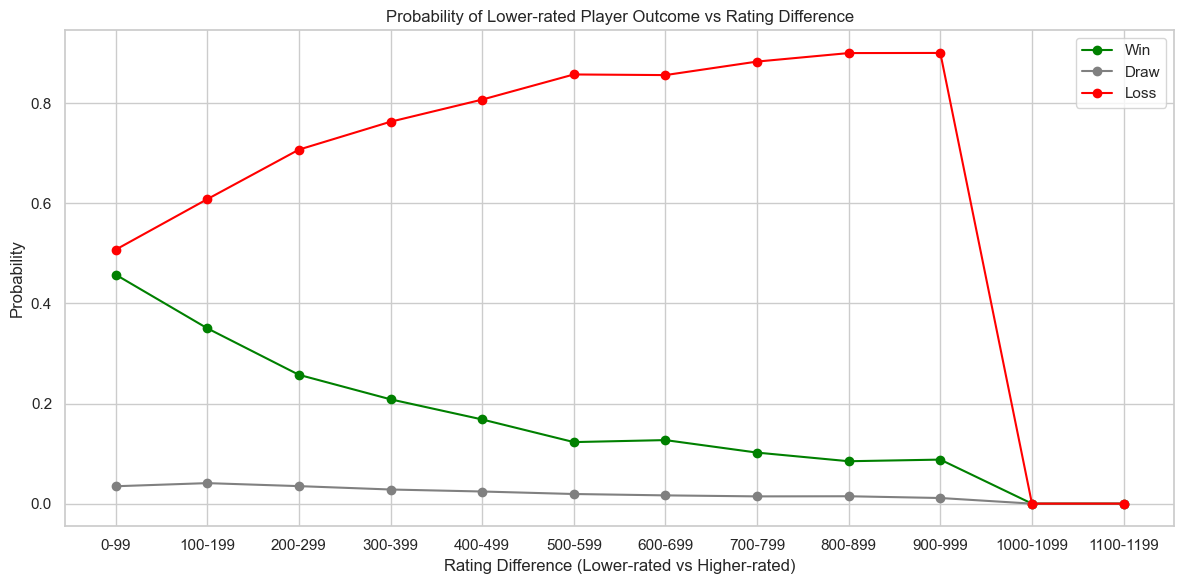

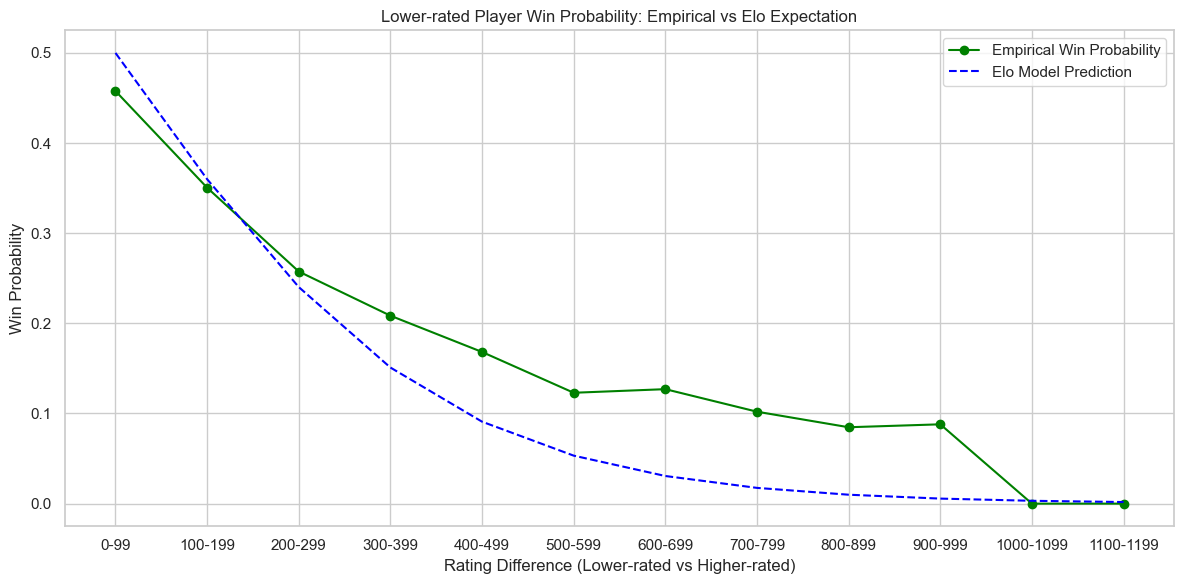


Chi-squared Test: chi2=3837.95, p-value=0.0000, dof=18
Reject null hypothesis: Lower-rated player outcome depends on rating difference bin.


In [43]:
"""
Lichess PGN Analysis Pipeline
Author: Joshua Tutin
Purpose: Analyze Lichess PGN data to study the probability of lower-rated player outcomes, 
perform EDA, hypothesis testing, and compare with Elo expectations.
"""

# ---------------- IMPORTS ----------------
import requests
import zstandard as zstd
import chess.pgn
from io import TextIOWrapper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, spearmanr

# ---------------- PARAMETERS ----------------
ZST_URL = "https://database.lichess.org/standard/lichess_db_standard_rated_2025-09.pgn.zst"
N_GAMES = 100000 # Approx total target across all bins
TARGET_PER_BIN = 4000  # Games per rating-difference bin
OUTPUT_CSV = "lichess_2025_games.csv"
PROB_OUTPUT_CSV = "lower_player_probabilities.csv"

# ---------------- HELPER FUNCTIONS ----------------
def safe_int(value):
    """Convert value to int safely, default 0."""
    try:
        return int(value)
    except (ValueError, TypeError):
        return 0

# --------------------------------------------------
# UPDATED DATA COLLECTION FUNCTION (LO1 & LO2)
# --------------------------------------------------
def download_and_extract_pgn(url: str, target_per_bin: int = TARGET_PER_BIN) -> pd.DataFrame:
    """
    Stream and decompress a Lichess PGN file, performing STRATIFIED SAMPLING
    across rating-difference bins (LO1: Data acquisition and cleaning).
    Each bin (0–99, 100–199, …) collects up to `target_per_bin` games (LO2: Sampling design).
    """
    # Define rating difference bins for stratified sampling
    bins = list(range(0, 1050, 100))
    labels = [f"{b}-{b+99}" for b in bins[:-1]]
    bin_counts = {label: 0 for label in labels}
    games_data = []

    print("[INFO] Starting stratified sampling from Lichess PGN stream...")
    print(f"[INFO] Target: {target_per_bin} games per bin across {len(labels)} bins (~{target_per_bin*len(labels)} total)")

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(r.raw) as reader:
            text_stream = TextIOWrapper(reader, encoding='utf-8', errors='ignore')

            # Continue until all bins filled (LO2: Sampling logic)
            while not all(c >= target_per_bin for c in bin_counts.values()):
                game = chess.pgn.read_game(text_stream)
                if game is None:
                    print("[WARN] End of stream reached before all bins filled.")
                    break

                headers = {k: game.headers.get(k, "") for k in game.headers}
                white_elo = safe_int(headers.get("WhiteElo", 0))
                black_elo = safe_int(headers.get("BlackElo", 0))
                result = headers.get("Result", "")
                if white_elo == 0 or black_elo == 0:
                    continue

                abs_diff = abs(white_elo - black_elo)
                bin_idx = int(abs_diff // 100)
                if bin_idx >= len(labels):
                    continue  # Skip very large differences

                label = labels[bin_idx]
                if bin_counts[label] >= target_per_bin:
                    continue  # Skip if bin full

                game_text = str(game)
                if len(game_text.strip()) < 40:
                    continue  # Skip corrupt or incomplete games

                games_data.append({
                    "white": headers.get("White", ""),
                    "black": headers.get("Black", ""),
                    "white_rating": white_elo,
                    "black_rating": black_elo,
                    "result": result,
                    "abs_diff": abs_diff,
                    "diff_bin": label,
                    "pgn": game_text
                })
                bin_counts[label] += 1

                # Progress log (LO1 evidence)
                if sum(bin_counts.values()) % 500 == 0:
                    filled = sum(1 for c in bin_counts.values() if c >= target_per_bin)
                    print(f"[INFO] {sum(bin_counts.values())} games collected, {filled}/{len(labels)} bins filled.")

    print(f"[INFO] Stratified sampling complete. Total games collected: {len(games_data)}")
    print("[INFO] Bin fill summary:")
    for k, v in bin_counts.items():
        print(f"  {k}: {v} games")

    return pd.DataFrame(games_data)

# --------------------------------------------------
def compute_lower_player_results(df: pd.DataFrame) -> pd.DataFrame:
    """Compute rating differences, lower-rated player outcome, and absolute differences."""
    df['rating_diff'] = df['white_rating'] - df['black_rating']

    def lower_result(row):
        if row['rating_diff'] >= 0:  # White higher-rated
            if row['result'] == '1-0': return 'loss'
            elif row['result'] == '0-1': return 'win'
            else: return 'draw'
        else:  # Black higher-rated
            if row['result'] == '1-0': return 'win'
            elif row['result'] == '0-1': return 'loss'
            else: return 'draw'

    df['lower_result'] = df.apply(lower_result, axis=1)
    df['abs_diff'] = df['rating_diff'].abs()
    return df

def bin_rating_differences(df: pd.DataFrame) -> pd.DataFrame:
    """Bin rating differences into specified intervals for analysis."""
    bins = list(range(0, 1300, 100))
    labels = [f"{b}-{b+99}" for b in bins[:-1]]
    df['diff_bin'] = pd.cut(df['abs_diff'], bins=bins, labels=labels, right=False)
    return df

def compute_probabilities(df: pd.DataFrame) -> pd.DataFrame:
    """Compute probabilities of win/draw/loss for lower-rated player by rating difference bins."""
    prob_df = df.groupby('diff_bin')['lower_result'].value_counts(normalize=True).unstack().fillna(0)
    prob_df = prob_df[['win', 'draw', 'loss']].reset_index()
    return prob_df

def visualize_probabilities(prob_df: pd.DataFrame):
    """Plot probabilities of lower-rated player outcomes."""
    sns.set(style="whitegrid", context="notebook")
    plt.figure(figsize=(12,6))
    plt.plot(prob_df['diff_bin'], prob_df['win'], label='Win', marker='o', color='green')
    plt.plot(prob_df['diff_bin'], prob_df['draw'], label='Draw', marker='o', color='gray')
    plt.plot(prob_df['diff_bin'], prob_df['loss'], label='Loss', marker='o', color='red')
    plt.xlabel("Rating Difference (Lower-rated vs Higher-rated)")
    plt.ylabel("Probability")
    plt.title("Probability of Lower-rated Player Outcome vs Rating Difference")
    plt.legend()
    plt.tight_layout()
    plt.show()

def hypothesis_test(df: pd.DataFrame):
    """Perform chi-squared test to check if outcome depends on rating difference bins."""
    contingency = pd.crosstab(df['diff_bin'], df['lower_result'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\nChi-squared Test: chi2={chi2:.2f}, p-value={p:.4f}, dof={dof}")
    if p < 0.05:
        print("Reject null hypothesis: Lower-rated player outcome depends on rating difference bin.")
    else:
        print("Fail to reject null hypothesis: No significant dependence found.")

# ---------------- MAIN PIPELINE ----------------
if __name__ == "__main__":
    # Step 1: Load or stream PGN dataset
    try:
        df = pd.read_csv(OUTPUT_CSV)
        print(f"[INFO] Loaded existing dataset: {OUTPUT_CSV}")
    except FileNotFoundError:
        df = download_and_extract_pgn(ZST_URL, TARGET_PER_BIN)
        df.to_csv(OUTPUT_CSV, index=False)
        print(f"[INFO] Dataset saved as {OUTPUT_CSV}")
    
    # Step 2: Process lower-rated player outcomes
    df = compute_lower_player_results(df)
    df = bin_rating_differences(df)

        # Step 3: Compute probabilities and save
    prob_df = compute_probabilities(df)
    prob_df.to_csv(PROB_OUTPUT_CSV, index=False)
    print(f"[INFO] Probabilities saved as {PROB_OUTPUT_CSV}\n")

    # Display the probability table (LO3: result summarization)
    print("[INFO] Lower-rated player outcome probabilities by rating-difference bin:\n")
    print(prob_df.to_string(index=False, formatters={
        'win': '{:.3f}'.format,
        'draw': '{:.3f}'.format,
        'loss': '{:.3f}'.format
    }))

    # Step 4: Visualizations (empirical data)
    visualize_probabilities(prob_df)

    # Step 5: Elo expectation comparison
    # -----------------------------------
    # Compute Elo expected win probability (for lower-rated player)
    elo_diffs = np.arange(0, 1300, 100)
    elo_expected_win = 1 / (1 + 10 ** (elo_diffs / 400))  # Standard Elo formula
    plt.figure(figsize=(12, 6))
    plt.plot(prob_df['diff_bin'], prob_df['win'], label='Empirical Win Probability', marker='o', color='green')
    plt.plot(prob_df['diff_bin'], elo_expected_win[:len(prob_df)], label='Elo Model Prediction', linestyle='--', color='blue')
    plt.xlabel("Rating Difference (Lower-rated vs Higher-rated)")
    plt.ylabel("Win Probability")
    plt.title("Lower-rated Player Win Probability: Empirical vs Elo Expectation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 6: Hypothesis testing
    hypothesis_test(df)

   



# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [42]:


# Safe Recursive Git Auto-Push for Jupyter Notebooks
# Skips notebooks with unresolved Git conflicts


import json
import subprocess
import hashlib
from pathlib import Path
from IPython.display import Javascript, display
import ipynbname
import datetime

def run_cmd(cmd, check=True, capture_output=False):
    """Run a shell command safely."""
    try:
        result = subprocess.run(cmd, check=check, capture_output=capture_output, text=True)
        if capture_output:
            return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        if capture_output:
            print(f"[ERROR] Command failed: {' '.join(cmd)}\n{e.stderr}")
        raise

def file_hash(path):
    """Compute MD5 hash of a file."""
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def is_valid_notebook(path):
    """Return True if the notebook is valid JSON and has no Git conflict markers."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            content = f.read()
            if "<<<<<<<" in content or ">>>>>>>" in content or "=======" in content:
                print(f"[WARN] Skipping {path} — contains Git conflict markers")
                return False
            json.loads(content)
        return True
    except json.JSONDecodeError:
        print(f"[WARN] Skipping {path} — invalid JSON")
        return False

# --------------------------
# 1️⃣ Save current notebook
# --------------------------
display(Javascript('IPython.notebook.save_checkpoint();'))
print("[INFO] Notebook checkpoint saved.")

# --------------------------
# 2️⃣ Detect project root
# --------------------------
try:
    notebook_path = ipynbname.path()
except Exception:
    raise RuntimeError("[ERROR] Cannot detect notebook path. Save and retry.")

project_root = Path(notebook_path).parents[1]  # adjust if your notebooks are deeper
print(f"[INFO] Using project root folder: {project_root}")

# --------------------------
# 3️⃣ Find all valid notebooks recursively
# --------------------------
all_notebooks = list(project_root.rglob("*.ipynb"))
valid_notebooks = [nb for nb in all_notebooks if is_valid_notebook(nb)]

if not valid_notebooks:
    print("[INFO] No valid notebooks to commit.")
else:
    print(f"[INFO] Found {len(valid_notebooks)} valid notebook(s).")

# --------------------------
# 4️⃣ Apply dummy update and commit modified notebooks
# --------------------------
modified_notebooks = []

for nb_path in valid_notebooks:
    old_hash = file_hash(nb_path)
    with open(nb_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Add a Markdown timestamp cell
    dummy_cell = {
        "cell_type": "markdown",
        "metadata": {},
        "source": [f"Auto-update: {datetime.datetime.now().isoformat()}\n"]
    }
    data["cells"].append(dummy_cell)

    with open(nb_path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=1)

    new_hash = file_hash(nb_path)
    if new_hash != old_hash:
        modified_notebooks.append(nb_path)

if modified_notebooks:
    for nb in modified_notebooks:
        run_cmd(["git", "add", "-f", str(nb)])
    commit_msg = f"Auto-update {len(modified_notebooks)} notebook(s)"
    result = subprocess.run(["git", "commit", "-m", commit_msg],
                            capture_output=True, text=True)
    print(f"[INFO] {result.stdout.strip().splitlines()[-1]}")
else:
    print("[INFO] No notebooks changed. Nothing to commit.")

# --------------------------
# 5️⃣ Detect current branch
# --------------------------
branch = run_cmd(["git", "branch", "--show-current"], capture_output=True) or "main"
print(f"[INFO] Current Git branch: {branch}")

# --------------------------
# 6️⃣ Push to GitHub
# --------------------------
try:
    run_cmd(["git", "push", "origin", branch])
    print(f"[SUCCESS] Pushed to GitHub branch: {branch}")
    print(f"🌐 View updates: https://github.com/JoshuaTutin/Capstone-Project/commits/{branch}")
except subprocess.CalledProcessError:
    print("[ERROR] Git push failed!")
    print("⚙️ Fix this by running manual push once with a Personal Access Token (PAT):")
    print("1️⃣ Ensure remote URL: git remote -v")
    print("2️⃣ Configure Git to store credentials: git config --global credential.helper store")
    print("3️⃣ Push manually: git push origin main (enter username + PAT)")








<IPython.core.display.Javascript object>

[INFO] Notebook checkpoint saved.
[INFO] Using project root folder: c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project
[WARN] Skipping c:\Users\joshu\OneDrive\Desktop\Coding projects\Capstone project\Capstone-Project\jupyter_notebooks\Notebook_Template.ipynb — contains Git conflict markers
[INFO] No valid notebooks to commit.
[INFO] No notebooks changed. Nothing to commit.
[INFO] Current Git branch: main
[ERROR] Git push failed!
⚙️ Fix this by running manual push once with a Personal Access Token (PAT):
1️⃣ Ensure remote URL: git remote -v
2️⃣ Configure Git to store credentials: git config --global credential.helper store
3️⃣ Push manually: git push origin main (enter username + PAT)
